In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
#this code dynamically creates a file path to a file named "housing.csv" located within the
#current working directory, making it adaptable regardless of where the script is executed
pwd = os.getcwd()
filepath = os.path.join(pwd, "housing.csv")
filepath

In [ ]:
housing_data = pd.read_csv(filepath)
housing_data

In [ ]:
housing_data.info()

In [ ]:
housing_data["ocean_proximity"].value_counts().plot(kind="barh")

In [ ]:
housing_data.describe()

In [ ]:
housing_data["median_income"].hist()

In [ ]:
housing_data["income_category"] = pd.cut(housing_data["median_income"],
                                        bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                                        labels=[1, 2, 3, 4, 5])
housing_data["income_category"].value_counts()

In [ ]:
housing_data["income_category"].hist()

In [ ]:
y = housing_data["median_house_value"]
X = housing_data.drop("median_house_value", axis=1)
X

# Split Datasets

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
X_train

In [ ]:
housing_data["income_category"].hist()

In [ ]:
X_train["income_category"].hist()

# Stratified Split

In [ ]:
    #This code snippet effectively splits our data into a stratified training set 
    #and a testing set using the StratifiedShuffleSplit class. The training set will 
    #have a similar distribution of income categories as the original data, which is 
    #important for machine learning tasks where class imbalances can lead to biased models.

    from sklearn.model_selection import StratifiedShuffleSplit
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

    for train_index, test_index in split.split(housing_data, housing_data["income_category"]):
        strat_train_set = housing_data.loc[train_index]
        strat_test_set = housing_data.loc[test_index]

In [ ]:
strat_test_set["income_category"].value_counts() / len(strat_test_set)

In [ ]:
strat_train_set.drop("income_category", axis="columns", inplace=True)
strat_test_set.drop("income_category", axis="columns", inplace=True)

# Visualizing our Data
Doing this upfront helps us create more objective visualizations by eliminating potential biases that can come with how we choose to present the data visually

## Histograms

In [ ]:
housing = strat_train_set.copy()

In [ ]:
housing

In [ ]:
housing.hist(bins=50, figsize=(20, 15))

In [ ]:
housing["median_income"].hist()

## Geographic Data

In [ ]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
            s=housing["population"]/100, label="population", figsize=(10,7),
            c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
            sharex=False)

## Correlation Matrices

In [ ]:
#faced error- 'could not convert string to float: 'INLAND''

# converting to numeric (replace other errors with 'coerce' as needed)
housing['ocean_proximity'] = pd.to_numeric(housing['ocean_proximity'], errors='coerce')

# Now 'housing.corr()' works without the error
correlation_matrix = housing.corr()

housing.corr()

In [ ]:
#This code creates a correlation heatmap using the Seaborn library to visualize the relationships between features in our
#housing DataFrame, allowing us to identify strong positive or negative relationships that might be relevant for further analysis.

import seaborn as sns
corr = housing.corr()

mask=np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
           square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Preparing Data for Machine Learnig

In [ ]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

## Dealing with Missing values

In [ ]:
#this code finds rows in housing that have at least one missing value and then displays 
#the first few of those rows (containing missing values) for further inspection.

sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

In [ ]:
sample_incomplete_rows.dropna(subset=["total_bedrooms"])

### Imputing data

In [ ]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

In [ ]:
housing_num = housing.select_dtypes(include=[np.number])
housing_num

In [ ]:
imputer.fit(housing_num)

In [ ]:
# this code takes a DataFrame housing_num, which contains numerical data related to housing,
# applies an imputation strategy to handle missing values, and then creates a new DataFrame 
# called 'housing_tr' containing the transformed data.

X = imputer.transform(housing_num)

housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)
housing_tr

In [ ]:
imputer.strategy

## Encoding Categorical Data

In [ ]:
housing_category = housing[["ocean_proximity"]]
housing_category.head(10)

In [ ]:
#this code segment uses OrdinalEncoder to convert categorical features in housing_category into numerical representations stored in housing_cat_encoded

from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_category)
housing_cat_encoded[:10]

In [ ]:
#this code snippet utilizes OneHotEncoder to convert categorical features in housing_category into one-hot encoded vectors, 
#then converts the resulting sparse matrix into a dense NumPy array for ease of use with various machine learning algorithms.

from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()

housing_cat_1hot = cat_encoder.fit_transform(housing_category)

housing_cat_1hot_dense = housing_cat_1hot.toarray()
housing_cat_1hot_dense

## Feature Engineering

In [ ]:
    def feature_engineering(data):
        data["bedrooms_per_household"] = data["total_bedrooms"] / data["households"]
        data["population_per_household"] = data["population"] / data["households"]
        data["rooms_per_household"] = data["total_rooms"] / data["households"]

        return data

In [ ]:
housing_feature_engineered = feature_engineering(housing_num)
housing_feature_engineered

## Scaling our Data

In [ ]:
#this code standardizes the features in housing_feature_engineered using StandardScaler, 
#ensuring that they are centered around zero and have a unit variance, which can often 
#improve the performance and convergence of machine learning algorithms.

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

housing_scaled = scaler.fit_transform(housing_feature_engineered)
housing_scaled

In [ ]:
ml_input_data = np.hstack([housing_cat_1hot_dense, housing_scaled])

In [ ]:
#this function encapsulates a complete data preprocessing pipeline, including handling missing values, 
# performing feature engineering, encoding categorical variables, and scaling numerical features

housing = strat_train_set.drop("median_house_value", axis=1)

housing_labels = strat_train_set["median_house_value"].copy()

def data_transformations(data):

    ### Separate Labels if they Exist ###

    if "median_house_value" in data.columns:
        labels = data["median_house_value"]
        data = data.drop("median_house_value", axis=1)
        
    else:
        labels = None

    ### Feature Engineering ###
    feature_engineered_data = feature_engineering(data)
    features = list(feature_engineered_data.columns) # Creating a list of our features for future use

    ### Imputing Data ###
    from sklearn.impute import SimpleImputer
    imputer = SimpleImputer(strategy="median")

    housing_num = feature_engineered_data.select_dtypes(include=[np.number])
    imputed = imputer.fit_transform(housing_num)

    ### Encoding Categorical Data ###
    housing_cat = feature_engineered_data.select_dtypes(exclude=[np.number])

    from sklearn.preprocessing import OneHotEncoder
    cat_encoder = OneHotEncoder()
    housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
    housing_cat_1hot_dense = housing_cat_1hot.toarray()
    features = features + cat_encoder.categories_[0].tolist()
    features.remove("ocean_proximity") # We're encoding this variable, so we don't need it in our list anymore


    ### Scaling Numerical Data ###
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()

    housing_scaled = scaler.fit_transform(imputed)

    ### Concatening all Data ###
    output = np.hstack([housing_scaled, housing_cat_1hot_dense])

    return output, labels, features

In [ ]:
cat_encoder.categories_[0].tolist()

# Select & train model

In [ ]:
train_data, train_labels, features= data_transformations(strat_train_set)
train_data

In [ ]:
features

In [ ]:
test_data, test_labels, features = data_transformations(strat_test_set)
test_data

## Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(train_data, train_labels)

In [ ]:
#comapre against test data
original_values = test_labels[:5]
predicted_values = lin_reg.predict(test_data[:5])

comparison_dataframe = pd.DataFrame(data={"Original values": original_values, "Predicted values": predicted_values})

comparison_dataframe["Differences"] = comparison_dataframe["Original values"] - comparison_dataframe["Predicted values"]
comparison_dataframe

In [ ]:
test_labels[:5]

In [ ]:
from sklearn.metrics import mean_squared_error

lin_mse = mean_squared_error(original_values, predicted_values)
lin_rmse = np.sqrt(lin_mse)

lin_rmse

## Decision Tree Regressor

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state = 42)
tree_reg.fit(train_data, train_labels)

In [ ]:
train_predictions = tree_reg.predict(train_data)
tree_mse = mean_squared_error(train_labels, train_predictions)
tree_rmse = np.sqrt(tree_mse)

### Cross-Validation

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, train_data, train_labels, scoring="neg_mean_squared_error", cv=10)

tree_rmse_scores = np.sqrt(-scores)

In [ ]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

### Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state = 42)
forest_reg.fit(train_data, train_labels)

In [ ]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, train_data, train_labels, scoring="neg_mean_squared_error", cv=10)

forest_rmse_scores = np.sqrt(-scores)
display_scores(forest_rmse_scores)

In [ ]:
scores = cross_val_score(lin_reg, train_data, train_labels, scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-scores)).describe()

## Fine-Tuning the model

In [ ]:
# After running this code, you can access the best parameters and best estimator 
# through grid_search.best_params_ and grid_search.best_estimator_ , respectively.

from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,scoring='neg_mean_squared_error',return_train_score=True)
grid_search.fit(train_data, train_labels)

In [ ]:
grid_search.best_estimator_

In [ ]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

### Randomized Search

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
    'n_estimators': randint(low=1, high=200),
    'max_features': randint(low=1, high=8),
}

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs, n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)

rnd_search.fit(train_data, train_labels)

In [ ]:
#this code snippet is useful for inspecting the results of a cross-validated grid search for hyperparameter tuning. 
#It prints out the root mean squared error, RMSE, for regression tasks along with the corresponding hyperparameters 
#for each model configuration tested during the grid search.

cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

In [140]:
#After running this code, we can analyze feature_importances to understand which features 
# were most influential in the model's predictions. This information can be valuable 
#for feature selection, understanding the dataset, and potentially improving the model.

feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([8.46978272e-02, 7.69983975e-02, 4.08715796e-02, 1.67325719e-02,
       1.71418340e-02, 1.73518185e-02, 1.56303531e-02, 3.39824215e-01,
       2.30528104e-02, 1.04033701e-01, 8.64983594e-02, 1.29273143e-02,
       1.54663950e-01, 7.22217547e-05, 3.62205279e-03, 5.88099358e-03])

### Feature Importance List

In [143]:
feature_importance_list = list(zip(features, feature_importances.tolist()))
feature_importance_list

[('longitude', 0.0846978271965227),
 ('latitude', 0.07699839747855737),
 ('housing_median_age', 0.040871579612884096),
 ('total_rooms', 0.016732571900462085),
 ('total_bedrooms', 0.01714183399184058),
 ('population', 0.0173518184721046),
 ('households', 0.015630353131298083),
 ('median_income', 0.3398242154869636),
 ('bedrooms_per_household', 0.023052810363875926),
 ('population_per_household', 0.10403370064780083),
 ('rooms_per_household', 0.08649835942626646),
 ('<1H OCEAN', 0.012927314349565632),
 ('INLAND', 0.15466394981681342),
 ('ISLAND', 7.222175467748088e-05),
 ('NEAR BAY', 0.003622052794433035),
 ('NEAR OCEAN', 0.005880993575933963)]

<BarContainer object of 16 artists>

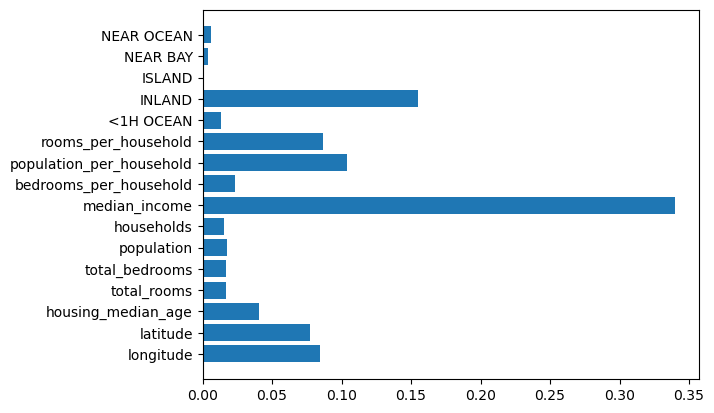

In [138]:
plt.barh(y=features, width=feature_importances.tolist())

In [136]:
final_model = grid_search.best_estimator_

final_predictions = final_model.predict(test_data)

final_mse = mean_squared_error(test_labels, final_predictions)
final_rmse = np.sqrt(final_mse)

In [137]:
final_rmse

63301.179203602675